# Example 1: The Knapsack Problem 

# Preamble

In [2]:
# Common imports
import numpy as np # numpy is THE toolbox for scientific computing with python
import pandas as pd # pandas provides THE data structure and data analysis tools for data scientists 

# maximum number of columns
pd.set_option("display.max_rows", 101)
pd.set_option("display.max_columns", 101)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

from warnings import filterwarnings
filterwarnings('ignore')

# The Knapsack Problem

We have a bag which can carry 35 kgs of weight. We can choose between 10 items, each with a specifc weight and price. We want to pick the items which maximize the value, i.e. the total price without exceeding the knapsack weight.

Let us start with defining the items in our knapsack:

In [4]:
np.random.seed(42)
item_number = np.arange(1,11)
weight      = np.random.randint(1,15, size = 10)
value       = np.random.randint(10,750, size = 10)
knapsack_threshold = 35

df = pd.DataFrame({'item_number':item_number,
                   'weight':weight,
                   'value':value})
display(df)

,item_number,weight,value
0,1,7,224
1,2,4,340
2,3,13,468
3,4,11,97
4,5,8,382
5,6,13,109
6,7,5,673
7,8,7,140
8,9,10,671
9,10,3,318


**Target**: Pick the items (item_number) which have highest value and do not exceed weight threshold.

# Setting the Scene

The GA begins with defining a chromosome (i.e an array of variable values) to be optimized:
$$ [p_1, p_2, \ldots, p_N] $$

For the knapsack problem it means if an item should be put into the bag or not:
$$ [1,0, 0, 0, 0,0,0,0,0,1] $$

*Note:* Binary Encoding is just one possible representation of chromosomes. For instance, in ordering problems like the traveling salesman problem **permutation encoding** is used.

The **cost function** $f$ is given as:
$$ cost = f(p_1, p_2, \ldots, p_N) $$

Note that the notions **cost function** and **fitness function** are normally used. The fitness function is the negative cost function. 

The GA starts with a group of chromosomes referred to as the **population**.

A population is evolved from one **generation** to the next and only the fittest survive. The selection rate $X_{rate}$ is the fraction of the population $N_{pop}$ that survives. The number of chromosomes kept is:

$$ N_{keep} = X_{rate} N_{pop} $$

We often keep $50 \%$ ($X_{rate} = 0.5$) in the natural selection process. 

# Initial population

In [28]:
np.random.seed(42)

solutions_per_pop  = 8
pop_size           = (solutions_per_pop, df.shape[0])
initial_population = np.random.randint(2, size = pop_size).astype(int)
# num_generations    = 50

print('Our initial population : \n \n', initial_population)

Our initial population : 
 
 [[0 1 0 0 0 1 0 0 0 1]
 [0 0 0 0 1 0 1 1 1 0]
 [1 0 1 1 1 1 1 1 1 1]
 [0 0 1 1 1 0 1 0 0 0]
 [0 0 1 1 1 1 1 0 1 1]
 [0 1 0 1 0 1 1 0 0 0]
 [0 0 0 0 0 1 1 0 1 1]
 [1 1 0 1 0 1 1 1 0 1]]


In [31]:
len(initial_population[0])

10

In [36]:
df

,item_number,weight,value
0,1,7,224
1,2,4,340
2,3,13,468
3,4,11,97
4,5,8,382
5,6,13,109
6,7,5,673
7,8,7,140
8,9,10,671
9,10,3,318


In [34]:
print('\n Selected items in our first chromosome of our starting population: \n')

weight_vec = [];
value_vec  = [];
for i in range(len(initial_population[0])):
    if initial_population[0][i] != 0:
        print('{}\n'.format(item_number[i]))
        print('Weight: {} \n'.format(weight[i]))
        weight_vec.append(weight[i])
        value_vec.append(value[i])
print('\n with total weight: \n')
print(np.array(weight_vec).sum())
print('\n and total value: \n')
print(np.array(value_vec).sum())


 Selected items in our first chromosome of our starting population: 

2

Weight: 4 

6

Weight: 13 

10

Weight: 3 


 with total weight: 

20

 and total value: 

767


The **fitness function of the knapsack problem** calculates the total value and the total weight. It is the total value of the chosen items, if the weight does not exceed the upper bound:

$$ f(p_1, p_2, \ldots, p_8) = \sum_{i=1}^{8} p_i v_i $$

$$ \sum_{i=1}^8 p_j w_j \leq M $$

In [37]:
def cal_fitness(weight, value, population, threshold):
    
    fitness = np.empty(population.shape[0])
    
    for i in range(population.shape[0]):
        S1 = np.sum(population[i] * value)
        S2 = np.sum(population[i] * weight)
        if S2 <= threshold:
            fitness[i] = S1
        else:
            fitness[i] = 0 

    return(pd.DataFrame({'fitness': fitness}))

In [39]:
fitness_df = cal_fitness(weight, value, initial_population, knapsack_threshold)
display(fitness_df)

,fitness
0,767.0
1,1866.0
2,0.0
3,0.0
4,0.0
5,1219.0
6,1771.0
7,0.0


Let us order the list for highest fitness value:

In [44]:
fitness_df.sort_values('fitness', ascending=False).reset_index()

,index,fitness
0,1,1866.0
1,6,1771.0
2,5,1219.0
3,0,767.0
4,2,0.0
5,3,0.0
6,4,0.0
7,7,0.0


Finally, only the fittest survive and the other elements of the initial population are discarded. 

# Selection

From the $N_{keep}$ chromosomes new offsprins are constructed. Pairing takes place unitl $N_{pop}-N_{keep}$ offsprings are born to replace the discarded chromosomes.

Pairing chromosomes in a GA can be as interesting and varied as pairing in an animal species. Different selection methods are:

* Pairing from top to bottom
* Random pairing
* Weighted random pairing
* Cost weighting: The probability of selection is calculated from the cost of the chromosome rather than its rank in the population. 
* Tournament selection

In [45]:
def selection(fitness_df, population, num_parents):
    
    parents_df = fitness_df.sort_values('fitness', ascending=False).reset_index()[:num_parents]
    parents    = population[parents_df['index']]
    return(parents)

We use 50% of our initial population for constructing offsprings:

In [46]:
selection_df = selection(fitness_df, initial_population, int(pop_size[0]/2))

In [47]:
selection_df

array([[0, 0, 0, 0, 1, 0, 1, 1, 1, 0],
       [0, 0, 0, 0, 0, 1, 1, 0, 1, 1],
       [0, 1, 0, 1, 0, 1, 1, 0, 0, 0],
       [0, 1, 0, 0, 0, 1, 0, 0, 0, 1]])

In [104]:
np.random.randint(0,len(parents))

1

In [106]:
# CROSS-OVER
np.random.seed(42)
parents = selection_df;

children = [];
#number of child chromosomes:
desired_length = solutions_per_pop - len(parents)
print(desired_length)

while len(children) < desired_length :
    male   = list(selection_df[np.random.randint(0,len(parents))])
    print('MALE   : ', male)
    female = list(selection_df[np.random.randint(0,len(parents))])
    print('FEMALE : ', female)
    half = int(len(male)/2)
    child = male[:half] + female[half:]
    print('CHILD  : ', child)
    children.append(child)
    print("=====================")

4
MALE   :  [0, 1, 0, 1, 0, 1, 1, 0, 0, 0]
FEMALE :  [0, 1, 0, 0, 0, 1, 0, 0, 0, 1]
CHILD  :  [0, 1, 0, 1, 0, 1, 0, 0, 0, 1]
MALE   :  [0, 0, 0, 0, 1, 0, 1, 1, 1, 0]
FEMALE :  [0, 1, 0, 1, 0, 1, 1, 0, 0, 0]
CHILD  :  [0, 0, 0, 0, 1, 1, 1, 0, 0, 0]
MALE   :  [0, 1, 0, 1, 0, 1, 1, 0, 0, 0]
FEMALE :  [0, 1, 0, 0, 0, 1, 0, 0, 0, 1]
CHILD  :  [0, 1, 0, 1, 0, 1, 0, 0, 0, 1]
MALE   :  [0, 0, 0, 0, 1, 0, 1, 1, 1, 0]
FEMALE :  [0, 0, 0, 0, 1, 0, 1, 1, 1, 0]
CHILD  :  [0, 0, 0, 0, 1, 0, 1, 1, 1, 0]


# Mutation

Now we change a subet of the child chromosomes with a given probability:

In [108]:
np.random.seed(42)
mutation_chance = 0.08

# Mutation
for child in children:
    print(child)
    if mutation_chance > np.random.random():
        r = random.randint(0,len(child)-1)
        if child[r] == 1:
            child[r] = 0
        else:
            child[r] = 1
    print(child)
    print("===================")

[0, 1, 0, 1, 0, 1, 0, 0, 0, 1]
[0, 1, 0, 1, 0, 1, 0, 0, 0, 1]
[0, 0, 0, 0, 1, 1, 1, 0, 0, 0]
[0, 0, 0, 0, 1, 1, 1, 0, 0, 0]
[0, 1, 0, 1, 0, 1, 0, 0, 0, 1]
[0, 1, 0, 1, 0, 1, 0, 0, 0, 1]
[0, 0, 0, 0, 1, 0, 1, 1, 1, 0]
[0, 0, 0, 0, 1, 0, 1, 1, 1, 0]


# The Next Generation & Convergence

In [112]:
# CROSS-OVER
def cross_over_mutation(solutions_per_pop, parents):
    
    children = [];
    desired_length = solutions_per_pop - len(parents)
 
    while len(children) < desired_length :
        male   = list(parents[np.random.randint(0,len(parents)-1)])
        female = list(parents[np.random.randint(0,len(parents)-1)])
        half = int(len(male)/2)
        child = male[:half] + female[half:]
        children.append(child)
        
    mutation_chance = 0.08

    # Mutation
    for child in children:
        if (mutation_chance > np.random.random()):
            r = np.random.randint(0,len(child)-1)
            if child[r] == 1:
                child[r] = 0
            else:
                child[r] = 1
 
    population = np.concatenate([parents, children], axis = 0)
    return(population)

In [114]:
def optimize(weight, value, population, num_generations, knapsack_threshold):
        
    pop_size = len(population[0])
    
    fitness_history = [];
    for i in range(num_generations):
        print('Generation : ', i)
        fitness_df = cal_fitness(weight, value, population, knapsack_threshold)
        parents_df = selection(fitness_df, population, int(len(population)/2))
        fitness_history.append(fitness_df)      
        population = cross_over_mutation(len(population), parents_df)
        
    print('Last generation: \n{}\n'.format(population)) 
    fitness_last_gen_df = cal_fitness(weight, value, population, knapsack_threshold)      
    print('Fitness of the last generation: \n{}\n'.format(fitness_last_gen_df))
    return(fitness_history)

In [115]:
fitness_history = optimize(weight, value, initial_population, 50, 70)

Generation :  0
Generation :  1
Generation :  2
Generation :  3
Generation :  4
Generation :  5
Generation :  6
Generation :  7
Generation :  8
Generation :  9
Generation :  10
Generation :  11
Generation :  12
Generation :  13
Generation :  14
Generation :  15
Generation :  16
Generation :  17
Generation :  18
Generation :  19
Generation :  20
Generation :  21
Generation :  22
Generation :  23
Generation :  24
Generation :  25
Generation :  26
Generation :  27
Generation :  28
Generation :  29
Generation :  30
Generation :  31
Generation :  32
Generation :  33
Generation :  34
Generation :  35
Generation :  36
Generation :  37
Generation :  38
Generation :  39
Generation :  40
Generation :  41
Generation :  42
Generation :  43
Generation :  44
Generation :  45
Generation :  46
Generation :  47
Generation :  48
Generation :  49
Last generation: 
[[0 1 1 1 1 1 1 0 1 1]
 [0 1 1 1 1 1 1 0 1 1]
 [0 1 1 1 1 1 1 0 1 1]
 [0 1 1 1 1 1 1 0 1 1]
 [0 1 1 1 1 1 1 0 1 1]
 [0 1 1 1 1 1 1 0 1 1]
 [0 

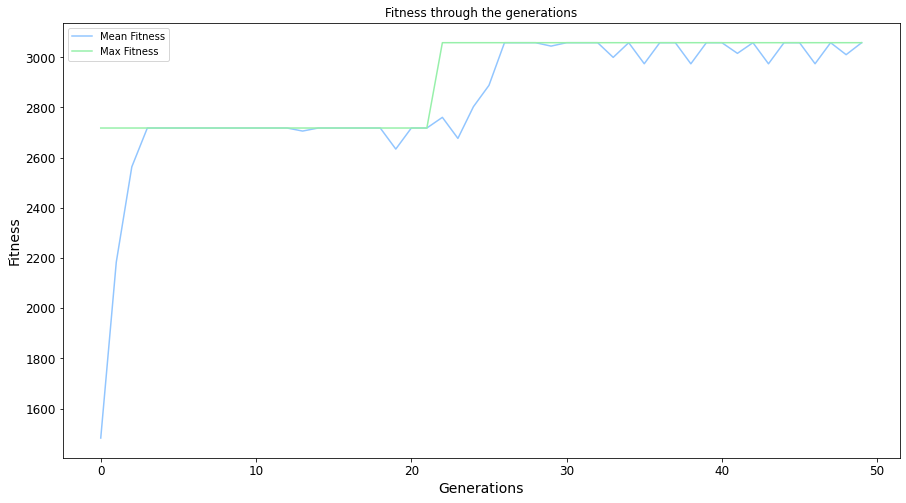

In [120]:
num_generations = 50; 

fig, axs = plt.subplots(figsize=(15, 8),nrows=1, ncols=1)
plt.style.use('seaborn-pastel')

fitness_history_mean = [np.mean(fitness) for fitness in fitness_history]
fitness_history_max  = [np.max(fitness) for fitness in fitness_history]
plt.plot(list(range(num_generations)), fitness_history_mean, label = 'Mean Fitness')
plt.plot(list(range(num_generations)), fitness_history_max, label = 'Max Fitness')
plt.legend()
plt.title('Fitness through the generations')
plt.xlabel('Generations')
plt.ylabel('Fitness')
plt.show()

# Example 2: Traveling Salesman

*Given a list of cities and the distances between each pair of cities, what is the shortest possible route that visits each city and returns to the original city?*

https://towardsdatascience.com/evolution-of-a-salesman-a-complete-genetic-algorithm-tutorial-for-python-6fe5d2b3ca35

Given this, there are two important rules to keep in mind:

*    Each city needs to be visited exactly one time
*    We must return to the starting city, so our total distance needs to be calculated accordingly

In [135]:
import numpy as np, random, operator, pandas as pd, matplotlib.pyplot as plt

In [121]:
class City:
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def distance(self, city):
        xDis = abs(self.x - city.x)
        yDis = abs(self.y - city.y)
        distance = np.sqrt((xDis ** 2) + (yDis ** 2))
        return distance
    
    def __repr__(self):
        return "(" + str(self.x) + "," + str(self.y) + ")"

In [122]:
class Fitness:
    def __init__(self, route):
        self.route = route
        self.distance = 0
        self.fitness= 0.0
    
    def routeDistance(self):
        if self.distance ==0:
            pathDistance = 0
            for i in range(0, len(self.route)):
                fromCity = self.route[i]
                toCity = None
                if i + 1 < len(self.route):
                    toCity = self.route[i + 1]
                else:
                    toCity = self.route[0]
                pathDistance += fromCity.distance(toCity)
            self.distance = pathDistance
        return self.distance
    
    def routeFitness(self):
        if self.fitness == 0:
            self.fitness = 1 / float(self.routeDistance())
        return self.fitness

In [123]:
def createRoute(cityList):
    route = random.sample(cityList, len(cityList))
    return route

In [124]:
def initialPopulation(popSize, cityList):
    population = []

    for i in range(0, popSize):
        population.append(createRoute(cityList))
    return population

In [138]:
def rankRoutes(population):
    fitnessResults = {}
    for i in range(0,len(population)):
        fitnessResults[i] = Fitness(population[i]).routeFitness()
    return sorted(fitnessResults.items(), key = operator.itemgetter(1), reverse = True)

In [126]:
def selection(popRanked, eliteSize):
    selectionResults = []
    df = pd.DataFrame(np.array(popRanked), columns=["Index","Fitness"])
    df['cum_sum'] = df.Fitness.cumsum()
    df['cum_perc'] = 100*df.cum_sum/df.Fitness.sum()
    
    for i in range(0, eliteSize):
        selectionResults.append(popRanked[i][0])
    for i in range(0, len(popRanked) - eliteSize):
        pick = 100*random.random()
        for i in range(0, len(popRanked)):
            if pick <= df.iat[i,3]:
                selectionResults.append(popRanked[i][0])
                break
    return selectionResults

In [127]:
def matingPool(population, selectionResults):
    matingpool = []
    for i in range(0, len(selectionResults)):
        index = selectionResults[i]
        matingpool.append(population[index])
    return matingpool

In [128]:
def breed(parent1, parent2):
    child = []
    childP1 = []
    childP2 = []
    
    geneA = int(random.random() * len(parent1))
    geneB = int(random.random() * len(parent1))
    
    startGene = min(geneA, geneB)
    endGene = max(geneA, geneB)

    for i in range(startGene, endGene):
        childP1.append(parent1[i])
        
    childP2 = [item for item in parent2 if item not in childP1]

    child = childP1 + childP2
    return child

In [129]:
def breedPopulation(matingpool, eliteSize):
    children = []
    length = len(matingpool) - eliteSize
    pool = random.sample(matingpool, len(matingpool))

    for i in range(0,eliteSize):
        children.append(matingpool[i])
    
    for i in range(0, length):
        child = breed(pool[i], pool[len(matingpool)-i-1])
        children.append(child)
    return children

In [130]:
def mutate(individual, mutationRate):
    for swapped in range(len(individual)):
        if(random.random() < mutationRate):
            swapWith = int(random.random() * len(individual))
            
            city1 = individual[swapped]
            city2 = individual[swapWith]
            
            individual[swapped] = city2
            individual[swapWith] = city1
    return individual

In [131]:
def mutatePopulation(population, mutationRate):
    mutatedPop = []
    
    for ind in range(0, len(population)):
        mutatedInd = mutate(population[ind], mutationRate)
        mutatedPop.append(mutatedInd)
    return mutatedPop

In [132]:
def nextGeneration(currentGen, eliteSize, mutationRate):
    popRanked = rankRoutes(currentGen)
    selectionResults = selection(popRanked, eliteSize)
    matingpool = matingPool(currentGen, selectionResults)
    children = breedPopulation(matingpool, eliteSize)
    nextGeneration = mutatePopulation(children, mutationRate)
    return nextGeneration

In [133]:
def geneticAlgorithm(population, popSize, eliteSize, mutationRate, generations):
    pop = initialPopulation(popSize, population)
    print("Initial distance: " + str(1 / rankRoutes(pop)[0][1]))
    
    for i in range(0, generations):
        pop = nextGeneration(pop, eliteSize, mutationRate)
    
    print("Final distance: " + str(1 / rankRoutes(pop)[0][1]))
    bestRouteIndex = rankRoutes(pop)[0][0]
    bestRoute = pop[bestRouteIndex]
    return bestRoute

In [136]:
cityList = []

for i in range(0,25):
    cityList.append(City(x=int(random.random() * 200), y=int(random.random() * 200)))

In [139]:
geneticAlgorithm(population=cityList, popSize=100, eliteSize=20, mutationRate=0.01, generations=500)

Initial distance: 1850.8940224711603
Final distance: 919.9887839375099


[(13,65),
 (23,68),
 (24,87),
 (50,92),
 (79,138),
 (159,192),
 (87,186),
 (71,187),
 (35,188),
 (0,187),
 (33,119),
 (45,110),
 (54,99),
 (73,77),
 (87,104),
 (100,120),
 (125,98),
 (126,93),
 (175,79),
 (152,98),
 (94,2),
 (66,31),
 (54,31),
 (49,29),
 (20,17)]

In [140]:
def geneticAlgorithmPlot(population, popSize, eliteSize, mutationRate, generations):
    pop = initialPopulation(popSize, population)
    progress = []
    progress.append(1 / rankRoutes(pop)[0][1])
    
    for i in range(0, generations):
        pop = nextGeneration(pop, eliteSize, mutationRate)
        progress.append(1 / rankRoutes(pop)[0][1])
    
    plt.plot(progress)
    plt.ylabel('Distance')
    plt.xlabel('Generation')
    plt.show()

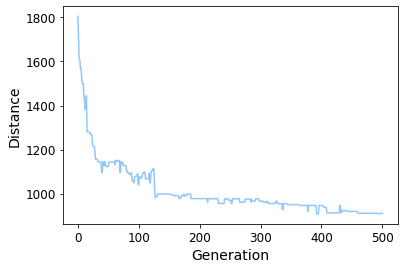

In [141]:
geneticAlgorithmPlot(population=cityList, popSize=100, eliteSize=20, mutationRate=0.01, generations=500)